In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display
import os
import pickle

import time

#!pip install torchsummary
from torchsummary import summary

#!pip install auraloss==0.3.0
#from torch.nn import MultiResolutionSTFTLoss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loader for MNIST

In [ ]:
# #loading dataset
# transform = transforms.ToTensor()

# train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
# train_data.shape
# # test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [ ]:
# # #train_loader = DataLoader(train_data, batch_size=10, shuffle=True) #original
# # #updated loaders with smaller train/test sets
#train_loader = DataLoader(torch.utils.data.Subset(train_data, range(5000)), batch_size=25, shuffle=True)
# # test_loader = DataLoader(torch.utils.data.Subset(train_data, range(5000, 12000)), batch_size=25, shuffle=False)
#train_loader.shape

# Implement audio preprocesessing.

In [ ]:
class PreprocessingPipeline:
  def __init__(self, SPECTROGRAMS_SAVE_DIR, FILES_DIR, SAMPLE_RATE, DURATION, MONO, FRAME_SIZE, HOP_LENGTH):
    self.file_path = FILES_DIR
    self.mono = MONO
    self.save_path = SPECTROGRAMS_SAVE_DIR
    self.sample_rate = SAMPLE_RATE
    self.duration = DURATION
    self.frame_size =  FRAME_SIZE
    self.hop_length = HOP_LENGTH
    self.num_expected_sample = int(self.sample_rate * self.duration)

  def _file_load(self, file_path):
    signal = librosa.load(file_path, sr = self.sample_rate, duration=self.duration, mono= self.mono)[0]
    return signal

  def _apply_padding(self, signal):
    num_missing_samples = self.num_expected_sample - len(signal)
    padded_signal = np.pad(signal, (0, num_missing_samples),mode="constant")
    #padded_signal = self.padder.right_pad(signal, num_missing_samples)
    return padded_signal

  def _extract_harmonics(self, signal):
    _harmonic = librosa.effects.harmonic(signal, margin=5.0)
    #_harmonic, _transient = librosa.effects.hpss(signal, margin=(3.0, 7.0))
    return _harmonic

  def augment_audio(self, signal):
    n_steps = np.random.randint(-1, 1)
    augmented_audio = librosa.effects.pitch_shift(signal, sr=self.sample_rate, n_steps=n_steps)
    return augmented_audio

  def _extract(self,signal):
    #n_fft = min(self.frame_size, len(signal))
    stft = librosa.stft(signal,n_fft=self.frame_size,hop_length=self.hop_length)[:-1]
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    return log_spectrogram

  def _save_feature(self, feature, file_path, count):
    save_path = self._generate_save_path(file_path, count)
    np.save(save_path, feature)

  def _save(self, data, save_path):
    with open(save_path, "wb") as f:
      pickle.dump(data, f)

  def _generate_save_path(self,file_path, count):
    file_name = os.path.split(file_path)[1]
    save_path = os.path.join(self.save_path, file_name + str(count) + ".npy")
    print(f"Saved: {self.save_path, file_name + str(count)}.npy")
    return save_path

  def process(self,audio_file_dir):
    file_count = 0
    for root, _, files in os.walk(audio_file_dir):
      for file in files:
        file_path = os.path.join(root, file)
        self._process_file(file_path)
        # if file_count < 5:
        #   signal = self.file_load(file_path)
        #   plt.figure(figsize=(20,7))
        #   librosa.display.waveshow(signal, sr = self.sample_rate)
        #   plt.title(f"Waveform of {file}")
        #   plt.show()
        #   file_count += 1
        #print(f"Processed file {file_path}")
    #self.saver.save_min_max_values(self.min_max_values)
    print("Files complete")

  def _process_file(self, file_path):
    signal = self._file_load(file_path)
    if len(signal) < self.num_expected_sample:
      signal = self._apply_padding(signal)
    pitch_count = 0
    # while pitch_count < 2:
    #   pitched_audio = self.augment_audio(signal)
    harmonic_signal = self._extract_harmonics(signal)
    feature = self._extract(harmonic_signal)
    self._save_feature(feature, file_path, pitch_count)
    #   pitch_count += 1

In [ ]:
class data_display():
  def __init__(self, data_source, sample_rate, hop_length,  scaler=None):
    self.data_source = data_source
    self.sample_rate = sample_rate
    self. hop_length = hop_length
    self.scaler = scaler


  def set_figsize(self, size="medium"):
    if size == "small":
      self.figsize =(4,3)
    elif size == "medium":
      self.figsize = (8,6)
    elif size == "large":
      self.figsize = (16,12)
    else:
      raiseValueError("invalid size. Please choose small, meduim, or large")


  def display_waveform(self):
    plt.figure(figsize=self.figsize)
    plt.grid(True)
    # Detach the tensor from the computation graph before plotting
    if isinstance(self.data_source, torch.Tensor):
      # Detach the tensor before converting to NumPy if it requires grad
      if self.data_source.requires_grad:
          data_to_plot = self.data_source[0, :, 0].detach().cpu().numpy()
      else:
          data_to_plot = self.data_source[0, :, 0].cpu().numpy()
    else:
        data_to_plot = self.data_source[0, :, 0]  # Assume NumPy array or similar

    plt.plot(data_to_plot, label=f'data{i}')
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    plt.legend()

  def display_spectrogram(self):
    plt.figure(figsize=self.figsize)
    self.reshaped_data = self.data_source[:, :, :].squeeze()
    print(self.reshaped_data.shape)
    # Check if self.reshaped_data is a PyTorch tensor
    if isinstance(self.reshaped_data, torch.Tensor):
        # Convert to NumPy array if it's a tensor
        self.reshaped_data = self.reshaped_data.cpu().detach().numpy()
    # Apply inverse transform to denormalize if scaler is provided
    if self.scaler is not None:
        self.reshaped_data = self.scaler.inverse_transform(self.reshaped_data)
    plt.axis("off")
    #spectrogram = librosa.amplitude_to_db(np.abs(self.reshaped_data), ref=np.max)
    img = librosa.display.specshow(self.reshaped_data, sr=self.sample_rate,hop_length=self.hop_length, x_axis='time', y_axis='log', cmap="magma")
    plt.title("Spectrogram")
    #plt.xlabel(f'Dimension length: {len(data[0,:,0])}')
    #plt.colorbar(img, ax=ax2, format="%+2.0f dB")  # Add colorbar to spectrogram
    plt.show()


In [ ]:
    frame_size = 2048
    hop_length = 512
    duration = 0.6  # in seconds
    sample_rate = 44100 #SR for kicks
    mono = True

    spectrograms_save_dir = "/content/drive/MyDrive/audio_samples/Kick_spectrograms"
    file_dir = "/content/drive/MyDrive/audio_samples/Analog_Kicks"

    preprocessing_pipeline = PreprocessingPipeline(spectrograms_save_dir, file_dir, sample_rate, duration, mono, frame_size, hop_length)
    preprocessing_pipeline.process(file_dir)

Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'XF_Kick_A_002.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 219.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 251.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 236.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 250.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 231.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 242.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 237.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 234 - G#.wav0').npy
Saved: ('/content/drive/MyDrive/audio_samples/Kick_spectrograms', 'Cheesy Cheese - 227 - G#.wav0').npy
Saved: ('/conten

In [ ]:

def load_spectrograms(spectrograms_path):
  _data_pool = []
  file_paths = []
  for root, _, file_names in os.walk(spectrograms_save_dir):
    for file_name in file_names:
      file_path = os.path.join(root, file_name)
      spectrogram = np.load(file_path)
      file_paths.append(file_path)
      _data_pool.append(spectrogram)
  _data_pool = np.array(_data_pool)
  #print(x_train.shape)
  _data_pool = _data_pool[:, np.newaxis, ...]
  print(f"data pool Shape:{_data_pool.shape}")
  return _data_pool, file_paths

data_pool, file_paths = load_spectrograms(spectrograms_save_dir)
print(f"Data pool max/min {data_pool.max(), data_pool.min()}")


data pool Shape:(474, 1, 1024, 52)
Data pool max/min (57.806763, -49.57982)


231
(1024, 52)


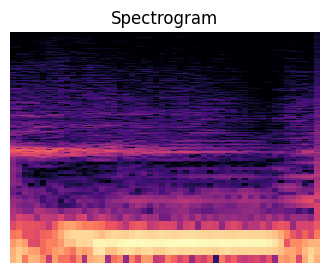

/content/drive/MyDrive/audio_samples/Kick_spectrograms/two-toner - old raw kick - F.wav0.npy
Max is 52.11246871948242, Min is -27.887531280517578
467
(1024, 52)


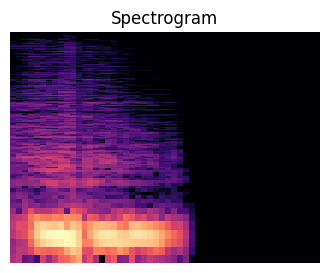

/content/drive/MyDrive/audio_samples/Kick_spectrograms/Tapete - Kick18 (Uptempo) A# 210BPM.wav0.npy
Max is 46.8355598449707, Min is -33.1644401550293
199
(1024, 52)


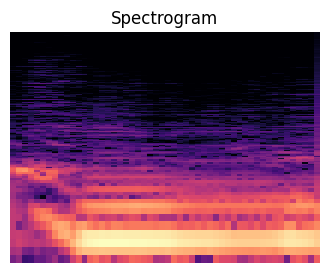

/content/drive/MyDrive/audio_samples/Kick_spectrograms/RVRITY - Kick 17 - G.wav0.npy
Max is 49.20697784423828, Min is -30.79302215576172


In [ ]:
import librosa.display
import random
for i in range(3):
  random_integer = random.randint(1,len(data_pool) -1)
  print(random_integer)
  data = data_pool[random_integer]

  original_image = data_display(data, sample_rate, hop_length, scaler=None)
      #original_image.display_waveform()
  original_image.set_figsize("small")
  original_image.display_spectrogram()
  # Create a figure and axes for the plots

  plt.show()
  print(file_paths[random_integer])
  print(f"Max is {data.max()}, Min is {data.min()}")

# Normalization

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1), clip=True)
# Normalize along the frequency and time dimensions (axes 2 and 3)
num_samples = data_pool.shape[0]
normalized_data_pool = np.zeros_like(data_pool, dtype=np.float32)
for i in range(num_samples):
    normalized_data_pool[i, 0] = scaler.fit_transform(data_pool[i, 0])
    # Applying fit_transform to each sample individually

print(normalized_data_pool.max())
print(normalized_data_pool.min())
print(f"Shape: {normalized_data_pool.shape}")

1.0
-1.0
Shape: (474, 1, 1024, 52)


# Creating Autoencoder

In [ ]:

class ConvolutionalNetwork(nn.Module):
    def __init__(self,input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim, padding, output_padding, device):
      super().__init__()
      self.input_shape = input_shape
      self.conv_filters = conv_filters
      self.conv_kernels = conv_kernels
      self.conv_strides = conv_strides
      self.latent_space_dim = latent_space_dim
      self.padding = padding
      self.output_padding = output_padding
      self.device = device


    #build initial model
    def build_model(self):
      self.encoder = self._build_encoder()

      #Create test input to get bottleneck and decoder shapes
      test_input = torch.randn(1, *self.input_shape)
      with torch.no_grad():
          test_output = self.encoder(test_input)
      self.shape_before_bottleneck = test_output.shape
      print(f"Shape before bottleneck is {self.shape_before_bottleneck}")
      self.encoder_output_size_flattened = torch.prod(torch.tensor(self.shape_before_bottleneck)).item()

      #build latent spacea and decoder
      self.mu, self.log_variance = self._build_latent_space()
      self.decoder = self._build_decoder()

      # Move the model components to the specified device
      self.to(device)


    def _build_encoder(self):
      encoder = nn.Sequential(
          nn.Conv2d(input_shape[0], conv_filters[0], kernel_size=conv_kernels[0], stride=conv_strides[0], padding=1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[0]),
          nn.Conv2d(conv_filters[0], conv_filters[1], kernel_size=conv_kernels[1], stride=conv_strides[1], padding=1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[1]),
          nn.Conv2d(conv_filters[1], conv_filters[2], kernel_size=conv_kernels[2], stride=conv_strides[2], padding=1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[2]),
          nn.Conv2d(conv_filters[2], conv_filters[3], conv_kernels[3], stride=conv_strides[3], padding=1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[3]),
          nn.Conv2d(conv_filters[3], conv_filters[4], conv_kernels[4], stride=conv_strides[4], padding=1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[4]),
          nn.Conv2d(conv_filters[4], conv_filters[5], conv_kernels[5], stride=conv_strides[5], padding=1),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[5])
      )
      return encoder

    def _build_decoder(self):
      decoder = torch.nn.Sequential(
          nn.Linear(latent_space_dim, self.encoder_output_size_flattened),
          nn.LeakyReLU(),
          nn.Unflatten(1, self.shape_before_bottleneck[1:]),
          nn.ConvTranspose2d(conv_filters[5], conv_filters[5], kernel_size=conv_kernels[5], stride=conv_strides[5], padding=padding[5], output_padding=output_padding[5]),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[5]),
          nn.ConvTranspose2d(conv_filters[5], conv_filters[4], kernel_size=conv_kernels[4], stride=conv_strides[4], padding=padding[0], output_padding=output_padding[0]),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[4]),
          nn.ConvTranspose2d(conv_filters[4], conv_filters[3], kernel_size=conv_kernels[3], stride=conv_strides[3], padding=padding[1], output_padding=output_padding[1]),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[3]),
          nn.ConvTranspose2d(conv_filters[3], conv_filters[2], kernel_size=conv_kernels[2], stride=conv_strides[2], padding=padding[2], output_padding=output_padding[2]),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[2]),
          nn.ConvTranspose2d(conv_filters[2], conv_filters[1], kernel_size=conv_kernels[1], stride=conv_strides[1], padding=padding[3], output_padding=output_padding[3]),
          nn.LeakyReLU(),
          nn.BatchNorm2d(num_features=conv_filters[1]),
          nn.ConvTranspose2d(conv_filters[1], 1, kernel_size=(conv_kernels[0]), stride=conv_strides[0], padding=padding[4], output_padding=output_padding[4]),
          nn.Tanh()  # Output in range [-1, 1]
      )
      return decoder

    def _build_latent_space(self):
      mu = nn.Linear(self.encoder_output_size_flattened, latent_space_dim)  # Define mu layer
      log_variance = nn.Linear(self.encoder_output_size_flattened, latent_space_dim)  # Define logvar layer
      return mu, log_variance

    #Run data through latent space
    def bottleneck(self, X):
      X = torch.flatten(X, start_dim=1)
      self.mu_tensor = self.mu(X)  # Use the defined mu layer
      self.log_variance_tensor = self.log_variance(X)  # Use the defined logvar layer
      epsilon = torch.randn_like(self.log_variance_tensor).to(device)
      return self.mu_tensor + torch.exp(0.5 * self.log_variance_tensor) * epsilon

    #calculate KL Loss
    def KL_divergence(self):
      return -0.5 * torch.sum(1 + self.log_variance_tensor - self.mu_tensor.pow(2) - torch.exp(self.log_variance_tensor), dim=1)
      #return KL_loss


    #main forward method
    def forward(self, input):
      encoded = self.encoder(input)
      bottleneck = self.bottleneck(encoded)
      decoded = self.decoder(bottleneck)
      return decoded

    #Reconstruction method for testing
    def reconstruct(self, images):
      encoded_image = self.encoder(images)
      latent_representations = self.bottleneck(encoded_image.to(self.device))
      reconstructed_images = self.decoder(latent_representations)
      return reconstructed_images, latent_representations




 ## Train the model
Creating class that will handle model training.

In [ ]:
class model_trainer():
  def __init__(self, train_loader, val_loader, epochs, KL_weight, patience, criterion, optimizer, model):
    super().__init__()
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.epochs = epochs
    self.KL_weight = KL_weight
    self.patience = patience
    self.criterion = criterion
    self.optimizer = optimizer
    self.train_losses = []
    self.val_losses = []
    self.KL_losses = []
    self.train_correct = []
    self.test_correct = []
    self.best_test_loss = float("inf")
    self.epochs_without_improvement = 0
    self.model = model
    self.start_time = time.time()

  def train(self):
    for i in range(epochs):
      # Run the training batches
      for b, data in enumerate(train_loader):
          b+=1

          X_train = data
          # Move X_train to the appropriate device
          X_train = X_train.to(device)

          # Apply the model
          y_pred = model(X_train)  # we don't flatten X-train here

          #caculate MSE_loss
          loss = criterion(y_pred, X_train)

          # KL_divergence loss
          KL_loss = model.KL_divergence()
          KL_loss = KL_loss.mean()
          self.KL_losses.append(KL_loss.item())

          # Print interim results
          if b%5 == 0:
              print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/420]  loss: {loss.item():10.8f}, KL-loss = {KL_loss}')

          #calculate KL_loss
          loss =  loss + KL_weight * KL_loss

          # Update parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          torch.cuda.empty_cache() #empty cache due to memory issues in Collab


      self.train_losses.append(loss.item())
      print(f'Training loss at Epoch {i} is {self.train_losses[-1]}')

      # Run the testing batches
      with torch.no_grad():
          for b, X_test in enumerate(val_loader):
              # Move X_test to the appropriate device
              X_test = X_test.to(device)
              y_val = model(X_test)
              val_loss = criterion(y_val, X_test)
              KL_loss = model.KL_divergence()
              KL_loss = KL_loss.mean()
              val_loss =  val_loss + KL_weight * KL_loss

      self.val_losses.append(val_loss.item())
      print(f'Validation loss at Epoch {i} is {self.val_losses[-1]}\n')
      #test_correct.append(tst_corr)

      #Early stopping check
      if self.train_losses[-1] < self.best_test_loss:
        self.best_test_loss = self.train_losses[-1]
        epochs_without_improvement = 0
      else:
        self.epochs_without_improvement += 1
        if self.epochs_without_improvement >= self.patience:
          print(f"Early stopping at epoch {i+1}")
          break

  #Retrun loss data for graphing
  def return_losses(self):
    return self.train_losses, self.val_losses
  #print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

# Training/Test batch declaration

In [ ]:
train_loader = DataLoader(torch.utils.data.Subset(normalized_data_pool, range(420)), batch_size=20, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(normalized_data_pool, range(421,450 )), batch_size=10, shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(normalized_data_pool, range(450, 771)), batch_size=4, shuffle=False)


# Training parameters and Initialization

In [ ]:
#memory management when using limited GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

torch.manual_seed(42)
input_shape= normalized_data_pool.shape[1:]
conv_filters=(1024, 1024, 512, 512, 256, 256)
conv_kernels=(3, 3, 3, 3, 3, 3)
conv_strides=(2, 2, 2, 2, (2,1), 2)

#padding for decoder
padding = (1,1,1,1,1,1)
output_padding = ((1,0),(1,0),(1,0),(1,1),(1,1),(1,1))
latent_space_dim= 2048
epochs = 100
KL_weight = .0001
patience = 12

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"The shape if the current input is {input_shape}")

model = ConvolutionalNetwork(input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim, padding, output_padding, device)
model.build_model()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


#summary(model, input_size=(1, 28, 28))
summary(model, input_size=input_shape)
#summary(model, input_size=(1, 56, 56))
print(input_shape)


The shape if the current input is (1, 1024, 52)
Shape before bottleneck is torch.Size([1, 256, 16, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 1024, 512, 26]          10,240
         LeakyReLU-2        [-1, 1024, 512, 26]               0
       BatchNorm2d-3        [-1, 1024, 512, 26]           2,048
            Conv2d-4        [-1, 1024, 256, 13]       9,438,208
         LeakyReLU-5        [-1, 1024, 256, 13]               0
       BatchNorm2d-6        [-1, 1024, 256, 13]           2,048
            Conv2d-7          [-1, 512, 128, 7]       4,719,104
         LeakyReLU-8          [-1, 512, 128, 7]               0
       BatchNorm2d-9          [-1, 512, 128, 7]           1,024
           Conv2d-10           [-1, 512, 64, 4]       2,359,808
        LeakyReLU-11           [-1, 512, 64, 4]               0
      BatchNorm2d-12           [-1, 512, 64, 4]           1,024


In [ ]:
train = model_trainer(train_loader, val_loader, epochs, KL_weight, patience, criterion, optimizer, model)
train.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.02 GiB. GPU 0 has a total capacity of 14.74 GiB of which 412.12 MiB is free. Process 3955 has 14.34 GiB memory in use. Of the allocated memory 14.15 GiB is allocated by PyTorch, and 52.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Plot the loss and accuracy comparisons

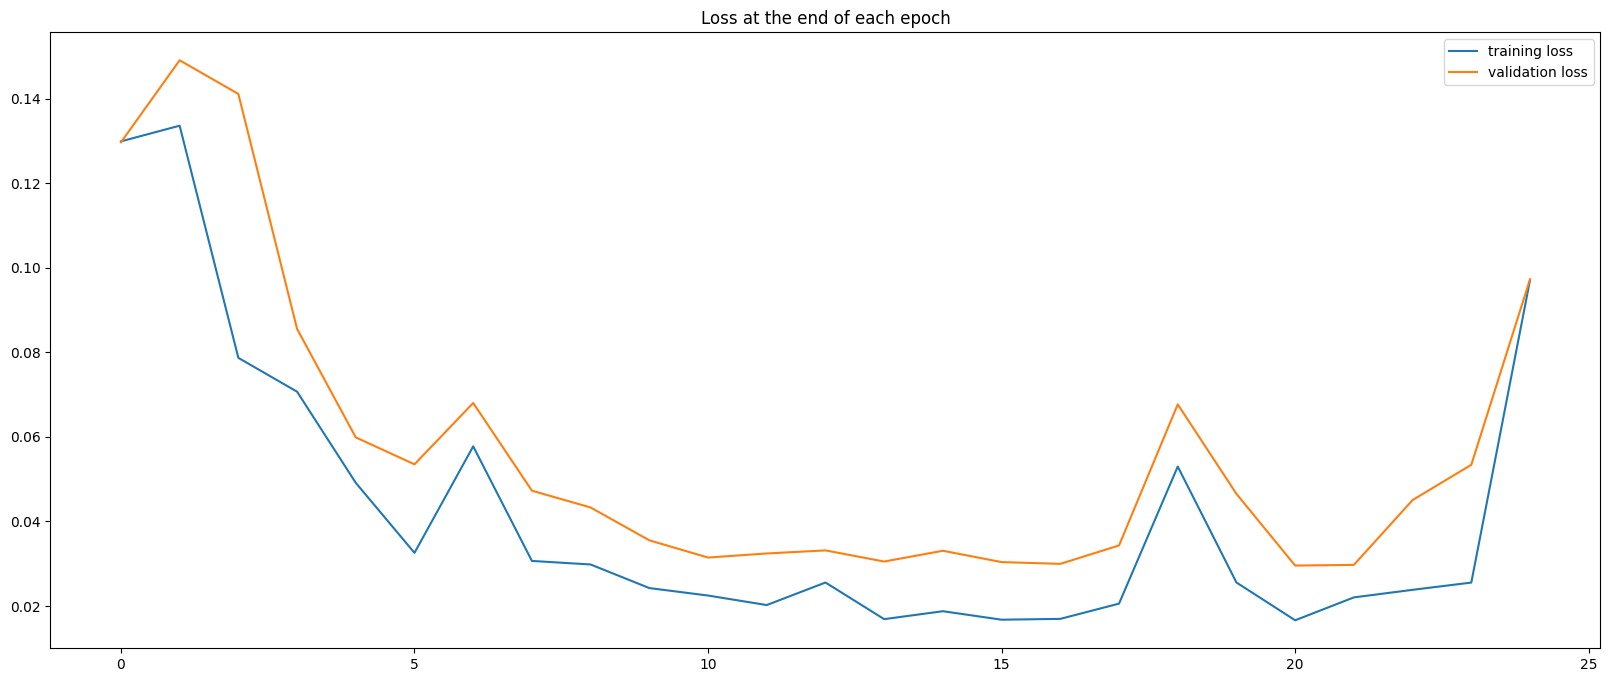

In [ ]:
train_losses, val_losses = train.return_losses()
plt.figure(figsize=(20, 8))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
#plt.plot(KL_losses, label='KL loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [ ]:
from IPython.display import Audio

def select_images(loader, num_images= 4):
    image_index = np.random.choice(len(loader.dataset), size=num_images, replace=False)
    sample_images = []
    for index in image_index:
        sample_images.append(torch.from_numpy(loader.dataset[index]))
    sample_images = torch.stack(sample_images)
    return sample_images

def plot_reconstructed_images(images, reconstructed_images):
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
      original_image = data_display(image, hop_length, sample_rate, scaler=scaler)
      original_image.set_figsize("small") #Call set_figsize before display_spectrogram
      #original_image.display_waveform()
      original_image.display_spectrogram()

      new_image = data_display(reconstructed_image, hop_length, sample_rate, scaler=scaler)
      new_image.set_figsize("small") #Call set_figsize before display_spectrogram
      #new_image.display_waveform()
      new_image.display_spectrogram()

def Latent_space_plot(latent_representation, sample_labels):
    plt.figure(figsize=(10,10))
    plt.scatter(latent_representation[:,0],
                latent_representation[:,1],
                cmap="viridis",
                c = sample_labels,
                alpha=.5,
                s=2)
    plt.colorbar()
    plt.show()


def convert_spectrograms_to_audio(sample_images, reconstructed_images, scaler):
    original_signals = []
    reconstructed_signals= []
    if reconstructed_images is not None and len(reconstructed_images) > 0:
      for spectrogram in reconstructed_images:
          # reshape the log spectrogram
          log_spectrogram = spectrogram[0,:, :].cpu().detach().numpy().squeeze()
          # apply denormalisation
          denormalized_spectrogram = scaler.inverse_transform(log_spectrogram)
          # log spectrogram -> spectrogram
          print(f"Max is {denormalized_spectrogram.max()}, Min is {denormalized_spectrogram.min()}")
          spec = librosa.db_to_amplitude(denormalized_spectrogram)
          # apply Griffin-Lim
          signal = librosa.istft(spec, hop_length=hop_length)
          # append signal to "signals"
          reconstructed_signals.append(signal)
    for spectrogram in sample_images:
        # reshape the log spectrogram
        log_spectrogram = spectrogram[0,:, :].cpu().detach().numpy().squeeze()
        # apply denormalisation
        denormalized_spectrogram = scaler.inverse_transform(log_spectrogram)
        # log spectrogram -> spectrogram
        print(f"Max is {denormalized_spectrogram.max()}, Min is {denormalized_spectrogram.min()}")
        spec = librosa.db_to_amplitude(denormalized_spectrogram)
        # apply Griffin-Lim
        signal = librosa.istft(spec, hop_length=hop_length)
        # append signal to "signals"
        original_signals.append(signal)

    for i in range(len(original_signals)):
        print(f"Audio Pair {i + 1}")
        display(Audio(original_signals[i], rate=sample_rate))  # Display original
        display(Audio(reconstructed_signals[i], rate=sample_rate))  # Display reconstructed

    return original_signals, reconstructed_signals

torch.Size([1024, 52])


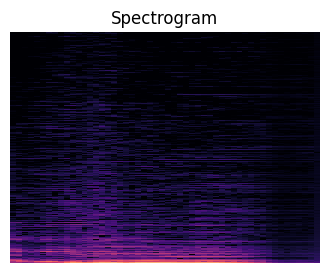

torch.Size([1024, 52])


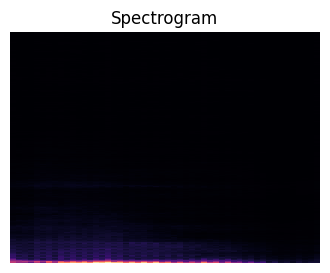

torch.Size([1024, 52])


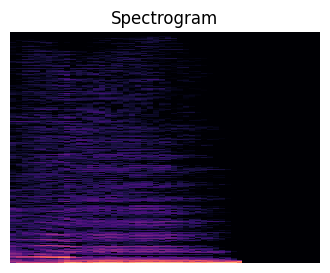

torch.Size([1024, 52])


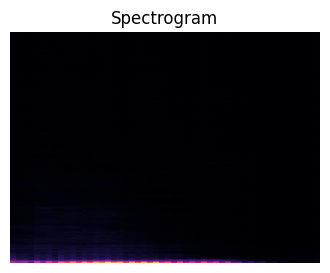

torch.Size([1024, 52])


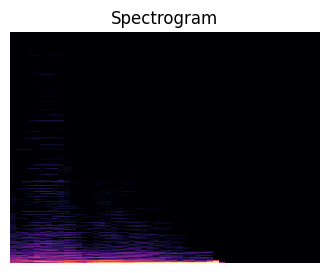

torch.Size([1024, 52])


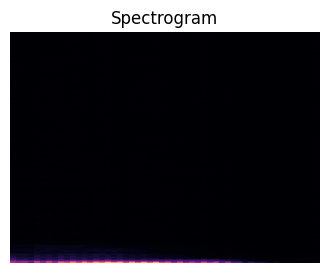

torch.Size([1024, 52])


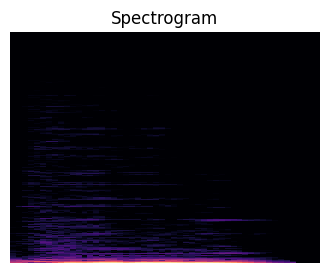

torch.Size([1024, 52])


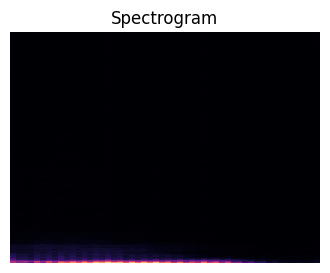

Max is 49.017547607421875, Min is -28.47792625427246
Max is 44.36250686645508, Min is -28.477399826049805
Max is 44.21143341064453, Min is -28.478864669799805
Max is 45.95549392700195, Min is -28.478059768676758
Max is 51.500919342041016, Min is -28.49907875061035
Max is 51.500919342041016, Min is -28.49907875061035
Max is 51.500919342041016, Min is -28.49907875061035
Max is 51.500919342041016, Min is -28.49907875061035
Audio Pair 1


Audio Pair 2


Audio Pair 3


Audio Pair 4


In [ ]:
num_samples = 4
model.eval()

sample_images = select_images(train_loader, num_samples)
sample_images = sample_images.to(device)
reconstructed_images, _ = model.reconstruct(sample_images)
plot_reconstructed_images(sample_images.cpu(), reconstructed_images.cpu())
original_audio, reconstructed_audio = convert_spectrograms_to_audio(sample_images, reconstructed_images, scaler)
# Audio(original_audio[0], rate=SAMPLE_RATE)
# Audio(reconstructed_audio[0], rate=SAMPLE_RATE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
